# Points to mention from this task
### (1) High dimension data

Among all datasets provided, I chose 'Lung' since it has the largest sample size, and I did not use gene fusions because only few cell models share the same gene fusion and while encoding this information, the impact is not sure whether it is positive or negative. Although I chose Lung which has the largest sample size, only 175 samples are in the data and the feasure space is much higher. So, I strugged to deal with high dimensional issue in which I decided to argument the data so that the algorithm can learn something from the data and selected 50 top features at each data based on variance of it. 

Transformer algorithm itself requires many parameters to be learned, so it has a risk in overfitting. Therefore, I tried to simplify the architecture as much as possible. But there are still memory issues. Thus, I reduced the architecture and did not use some data unless it has clear relevance to the data. 


### (2) Memory issue

On top of high dimensional issue, I used my personal computer, so there is a limited memory for GPU. I only have 4 GB GPU memory but more memory (64GB) in CPU. Thus, I tried to use them both if possible. If I can use HPC, then the algorithm would be more powerful in terms of performance. 


### (3) Hard to beat a linear model

I started off with applying a linear model, and it showed actually great performance in any circumstances. So, I thought this data was synthetic data generated with strong impacts of linearity. When I checked the correlation between input and output, it was around 30%, so I guess there should be a space to learn non-linearity which is an edge from transformer. However, after implementing several variants of transformers, I came to think the impact from linear relation should be higher than non-linearity. Sometimes, it beats a linear model. However, the difference was negligible. So, I just showed the case of self attention reaching stably similar performance with a linear model. If I face this data in reality under the same constraints, I would just use a linear model. 


### (4) Alternative ideas

I thought copy number variation and methylation is relevant to gene regulation. So, I believe there might be some non-linear relationship between both of these and transcriptomics. Therefore, I added cross-attention to them and self attention to others, and combined them together with outcome in the end. Due to lack of time and capacity in my computer, I was not able to put the results here. But the performance was similar and a bit less than self attention. I guess biologically it was meaningful approach, but it has much more parameters to learn because of cross-attention. With enough computational power, it should give us better results. 

Positional encoding was surprisingly working well. I thought the order of proteomics is random in the data. So, I decided not to use positional encoding, but it showed significant improvement in performance. However, I still think the data should be ordered biologically such as known relationships between different proteins. I wanted to combine transformer with graph attention network (GAT) by using STRING database which is protein-protein interaction network information. However, then I needed to use datasets out of lists provided. So, I do not think this is right aim of this task. If there is a possiblity to work further later, it might be interesting to integrate network information and learn network structure, and link those data to positional encoding in transformer. 





# Implementation steps
- [1] Load packages and define functions
- [2] Load the config.yaml file
- [3] Load and preprocess data
- [4] Model training and evaluation
- [5] Visualize the model performance for comparison
- [6] Calculate R² scores for each feature and output a list of top-performing features

## [1] Load packages and define functions

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tqdm.keras import TqdmCallback
import yaml
import os
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
import random
import optuna

# Set up a mixed precision to reduce computational burden like memory issue
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Define a function to monitor and display the current memory usage of the running process
def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# Define a function to augment data by adding random noise for increased dataset size to avoid high-dimensional issue
def augment_data(data, factor, seed):
    np.random.seed(seed)
    augmented = [data]
    for _ in range(factor - 1):
        noise = np.random.normal(0, 0.01, data.shape)
        augmented.append(data + noise)
    return np.concatenate(augmented, axis=0)

### Self attention - I applied self attention to each dataset individually and combined them together with outcome after the self attention. 
# Define a positional encoding - In the begining, I did not use positional information since it is not aligned physical location or coexpression or somehting. But to get the benefit from transformer, I added it in the end and it turned out it has an impact on the performance. 
def positional_encoding(length, d_model):
    """sine and cosine based positional encoding"""
    position = np.arange(length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    pos_enc = np.zeros((length, d_model))
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)
    return tf.constant(pos_enc, dtype=tf.float16)[tf.newaxis, :, :]  # changed to float16 for memory issue 

# Define a self attention model function
def build_self_attention_model(input_data, config):
    inputs = {name: layers.Input(shape=(input_data[name].shape[1],)) for name in sorted(config['names'])}
    d_model = config['d_model']
    
    reshaped = {name: layers.Reshape((input_data[name].shape[1], 1))(inputs[name]) for name in sorted(config['names'])}
    embedded = {name: layers.Dense(d_model)(reshaped[name]) for name in sorted(config['names'])}
    
    attentions = {}
    for name in sorted(config['names']):
        x = embedded[name]
        pos_enc = tf.keras.layers.Lambda(lambda x: positional_encoding(x.shape[1], d_model))(x)
        x = x + pos_enc
        
        # 4th layer of attention + FFN(feed-forward network) with Pre-LN(pre-layer normalization) for stable optimization
        for _ in range(4):
            # Pre-LN for Attention
            x_norm = layers.LayerNormalization()(x)
            attn = layers.MultiHeadAttention(num_heads=config['num_heads'], key_dim=config['key_dim'])(x_norm, x_norm)
            x = attn + x  # Residual connection
            
            # Pre-LN for FFN 
            x_norm = layers.LayerNormalization()(x)
            ffn = layers.Dense(d_model * 4, activation='relu')(x_norm)
            ffn = layers.Dense(d_model)(ffn)
            x = ffn + x  # Residual connection
        
        attentions[name] = x
    
    # Combine and flatten data 
    combined = layers.Concatenate(axis=1)([attentions[name] for name in sorted(config['names'])])
    flattened = layers.Flatten()(combined)
    flattened = layers.Dropout(0.2)(flattened)
    
    # FC Layer
    output = layers.Dense(outcome_data.shape[1], activation='linear')(flattened)
    
    # Create a Keras Model by specifying the inputs and outputs
    model = tf.keras.Model(inputs=[inputs[name] for name in sorted(config['names'])], outputs=output)
    
    # Compile the model to configure it for training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['training']['learning_rate'], clipnorm=1.0),
        loss='mse'
    )
    return model

# For comparison, I also run RNN as a standard seq2seq algorithm, but I expect the performance from RNN should be bad since it has a position dependency in the algorithm. However, my data is arranged randomly which is not ideal set-up for RNN. 
def build_rnn_model(input_data, config):
    inputs = {name: layers.Input(shape=(input_data[name].shape[1], 1)) for name in sorted(config['names'])}
    lstms = {name: layers.LSTM(config['lstm_units'])(inputs[name]) for name in sorted(config['names'])}
    combined = layers.Concatenate()([lstms[name] for name in sorted(config['names'])])
    output = layers.Dense(outcome_data.shape[1], activation='linear')(combined)
    model = tf.keras.Model(inputs=[inputs[name] for name in sorted(config['names'])], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['training']['learning_rate']), loss='mse')
    return model

# Evaluation function - I used MSE, MAE, pearson correlation, and R2 as performance measures since this is a multivariate multiple regression problem. 
def evaluate_performance(true, pred, model_name, fold_results, fold, display_name=None):
    mse_fn = tf.keras.losses.MeanSquaredError()
    mse = mse_fn(true, pred).numpy()
    mae = np.mean(np.abs(true - pred))
    pearson_corrs = [pearsonr(true[:, i], pred[:, i])[0] for i in range(true.shape[1]) 
                     if not np.isnan(pearsonr(true[:, i], pred[:, i])[0])]
    avg_pearson = np.mean(pearson_corrs)
    r2 = r2_score(true, pred, multioutput='uniform_average')
    display_name = display_name or model_name
    print(f"{display_name} Fold {fold} - MSE: {mse:.4f}, MAE: {mae:.4f}, Avg Pearson Correlation: {avg_pearson:.4f}, R² Score: {r2:.4f}")
    fold_results[model_name].append({'mse': mse, 'mae': mae, 'pearson': avg_pearson, 'r2': r2})
    return mse, mae, avg_pearson, r2

# Plotting function
def plot_results(avg_results, models):
    display_names = [m.replace('_', ' ').title() for m in models]
    mse_values = [avg_results[m]['mse'] for m in models]
    mae_values = [avg_results[m]['mae'] for m in models]
    pearson_values = [avg_results[m]['pearson'] for m in models]
    r2_values = [avg_results[m]['r2'] for m in models]

    sns.set(style="whitegrid")
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

    sns.barplot(x=display_names, y=mse_values, ax=ax1, palette="Blues_d")
    ax1.set_title('Average Mean Squared Error (MSE)')
    ax1.set_ylabel('MSE')

    sns.barplot(x=display_names, y=mae_values, ax=ax2, palette="Purples_d")
    ax2.set_title('Average Mean Absolute Error (MAE)')
    ax2.set_ylabel('MAE')

    sns.barplot(x=display_names, y=pearson_values, ax=ax3, palette="Greens_d")
    ax3.set_title('Average Pearson Correlation')
    ax3.set_ylabel('Pearson Correlation')

    sns.barplot(x=display_names, y=r2_values, ax=ax4, palette="Reds_d")
    ax4.set_title('Average R² Score')
    ax4.set_ylabel('R²')

    plt.tight_layout()
    plt.show()
    
def analyze_feature_performance(true, pred, feature_names=None, top_n=10):
    """
    Calculate R² scores for each feature and output a list of top-performing features.
    
    Parameters:
    - true: Ground truth values (test_outcome, shape: [n_samples, n_features])
    - pred: Predicted values (self_pred, shape: [n_samples, n_features])
    - feature_names: List of feature names (optional, defaults to indices if None)
    - top_n: Number of top features to display (default: 10)
    """
    # Calculate R² for each feature
    feature_r2_scores = []
    for i in range(true.shape[1]):
        r2 = r2_score(true[:, i], pred[:, i])
        feature_r2_scores.append((i, r2))
    
    # Sort features by R² in descending order and extract top_n
    feature_r2_scores.sort(key=lambda x: x[1], reverse=True)
    top_features = feature_r2_scores[:top_n]
    
    # Use feature names if provided, otherwise use indices
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(true.shape[1])]
    
    # Print results
    print(f"Top {top_n} Best Predicted Features:")
    for idx, r2 in top_features:
        print(f"  {feature_names[idx]}: R² = {r2:.4f}")
    
    return top_features

## [2] Load the config.yaml file

In [2]:
# Get the current script's directory 
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Set the project root directory
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Change the working directory to the project root
os.chdir(project_root)

with open(os.path.join(project_root, 'config.yaml'), "r") as file:
    config = yaml.safe_load(file)

data_files = config['data']
preproc_config = config['preprocessing']
model_config = config['models']
cv_config = config['cross_validation']
random_seed = config['random_seed']
outcome_name = config['outcome_name']

## [3] Load and preprocess data

In [3]:
# Set random seeds for reproducibility
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Define data names, excluding outcome_name and gene_fusions. I think the information from gene fusion would be harmful for our prediction because of ambiguity of the effects. So, I decdied to remove it from my data used for analysis.
data_names = [name for name in data_files.keys() if name != outcome_name and name != 'gene_fusions']

input_data = {}
scaler = StandardScaler()
for name in data_names:
    print(f"Loading dataset: {name}")
    data = pd.read_csv(data_files[name], index_col=0).astype('float32').values
    print(f"Original {name} shape: {data.shape}")
    
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    print(f"Adjusted {name} shape: {data.shape}")
    
    variances = np.var(data, axis=0)
    print(f"Variances shape for {name}: {variances.shape}")
    
    n_features = data.shape[1]
    top_features = min(preproc_config['top_features'], n_features)
    top_indices = np.argsort(variances)[-top_features:]
    data = scaler.fit_transform(data[:, top_indices])
    data = augment_data(data, factor=preproc_config['augmentation_factor'], seed=random_seed)
    print(f"Augmented {name} shape: {data.shape}")
    
    input_data[name] = data

# Load and augment outcome data
outcome_data = pd.read_csv(data_files[outcome_name], index_col=0).astype('float32').values
print(f"Original {outcome_name} shape: {outcome_data.shape}")
if outcome_data.ndim == 1:
    outcome_data = outcome_data.reshape(-1, 1)
outcome_data = augment_data(outcome_data, factor=preproc_config['augmentation_factor'], seed=random_seed)
print(f"Augmented {outcome_name} shape: {outcome_data.shape}")

# Verify sample sizes dynamically
total_samples = input_data[data_names[0]].shape[0]
for name in data_names:
    assert input_data[name].shape[0] == total_samples, f"Sample size mismatch for {name}: {input_data[name].shape[0]}"
assert outcome_data.shape[0] == total_samples, f"{outcome_name} sample size mismatch: {outcome_data.shape[0]}"

# Combine input data for Linear Regression. As a basic model, I used multivariate multiple linear regression to this task. 
combined_input = np.concatenate([input_data[name] for name in data_names], axis=1)
print(f"Combined input shape for Linear Regression: {combined_input.shape}")

# Define K-Fold Cross Validation from config
kf = KFold(n_splits=cv_config['n_folds'], shuffle=True, random_state=random_seed)
fold_results = {model: [] for model in model_config.keys()}

Loading dataset: copy_number_variation
Original copy_number_variation shape: (175, 777)
Adjusted copy_number_variation shape: (175, 777)
Variances shape for copy_number_variation: (777,)
Augmented copy_number_variation shape: (525, 50)
Loading dataset: drug_response
Original drug_response shape: (175, 810)
Adjusted drug_response shape: (175, 810)
Variances shape for drug_response: (810,)
Augmented drug_response shape: (525, 50)
Loading dataset: metabolomics
Original metabolomics shape: (175, 225)
Adjusted metabolomics shape: (175, 225)
Variances shape for metabolomics: (225,)
Augmented metabolomics shape: (525, 50)
Loading dataset: methylation
Original methylation shape: (175, 14608)
Adjusted methylation shape: (175, 14608)
Variances shape for methylation: (14608,)
Augmented methylation shape: (525, 50)
Loading dataset: transcriptomics
Original transcriptomics shape: (175, 15278)
Adjusted transcriptomics shape: (175, 15278)
Variances shape for transcriptomics: (15278,)
Augmented transc

## [4] Model training and evaluation

In [5]:
# Perform K-Fold Cross Validation
# Defined a K-Fold
kf = KFold(n_splits=cv_config['n_folds'], shuffle=True, random_state=random_seed)
fold_results = {model: [] for model in model_config.keys()}

fold = 1
for train_idx, test_idx in kf.split(combined_input):
    print(f"\nProcessing Fold {fold}")
    
    # For a linear model, I combined the all features so it cannot be distinguished in the algorithm. 
    train_input = combined_input[train_idx]
    test_input = combined_input[test_idx]
    
    # For outcome, proteomics data is located with index for train and test. 
    train_outcome = outcome_data[train_idx]
    test_outcome = outcome_data[test_idx]
    
    # For self attention, I used each dataset individually and run self atteention to each of them and combine the results in the end with outcome. 
    train_data = {name: input_data[name][train_idx] for name in sorted(model_config['self_attention']['names'])}
    test_data = {name: input_data[name][test_idx] for name in data_names}
    
    # test data setup for each method
    test_data_rnn = {name: data[..., np.newaxis] for name, data in test_data.items()}
    test_data_self = [test_data[name] for name in sorted(model_config['self_attention']['names'])]
    test_data_cross = [
        *[test_data[name] for name in sorted(model_config['cross_attention']['self_attention_names'])],
        *[test_data[name] for name in sorted(model_config['cross_attention']['cross_attention_names'])]
    ]

    # Linear regression model fitting 
    linear_model = LinearRegression()
    linear_model.fit(train_input, train_outcome)
    linear_pred = linear_model.predict(test_input)
    evaluate_performance(test_outcome, linear_pred, "linear_regression", fold_results, fold, display_name="Linear Regression")

    # Self-attention model fitting 
    self_attention_model = build_self_attention_model(train_data, model_config['self_attention'])
    self_attention_model.fit(
    [train_data[name] for name in sorted(model_config['self_attention']['names'])],
    train_outcome,
    epochs=model_config['self_attention']['training']['epochs'],
    batch_size=model_config['self_attention']['training']['batch_size'],
    validation_split=model_config['self_attention']['training']['validation_split'],
    callbacks=[TqdmCallback(verbose=1)],
    verbose=0
    )

    self_pred = self_attention_model.predict(test_data_self)
    evaluate_performance(test_outcome, self_pred, "self_attention", fold_results, fold, display_name="Self-Attention")
   
   # RNN model fitting
    input_data_rnn = {name: train_data[name][..., np.newaxis] for name in sorted(model_config['rnn']['names'])}
    rnn_model = build_rnn_model(input_data, model_config['rnn'])
    rnn_model.fit(
            [input_data_rnn[name] for name in sorted(model_config['rnn']['names'])],
            train_outcome,
            epochs=model_config['rnn']['training']['epochs'],
            batch_size=model_config['rnn']['training']['batch_size'],
            validation_split=model_config['rnn']['training']['validation_split'],
            callbacks=[TqdmCallback(verbose=1), 
                       tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=model_config['rnn']['training']['patience'])],
            verbose=0
        )
    rnn_pred = rnn_model.predict([test_data_rnn[name] for name in sorted(model_config['rnn']['names'])])
    evaluate_performance(test_outcome, rnn_pred, "rnn", fold_results, fold, display_name="RNN")

    fold += 1

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA T400 4GB, compute capability 7.5

Processing Fold 1
Linear Regression Fold 1 - MSE: 0.0926, MAE: 0.1318, Avg Pearson Correlation: 0.8856, R² Score: 0.7499


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Processing Fold 1
Linear Regression Fold 1 - MSE: 0.0894, MAE: 0.1279, Avg Pearson Correlation: 0.8953, R² Score: 0.7646


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

9/9 [==============================] - 2s 59ms/step
Self-Attention Fold 1 - MSE: 0.1105, MAE: 0.2191, Avg Pearson Correlation: 0.8793, R² Score: 0.7167


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

9/9 [==============================] - 1s 18ms/step
RNN Fold 1 - MSE: 0.2754, MAE: 0.3797, Avg Pearson Correlation: 0.5865, R² Score: 0.3411


## [5] Visualize the model performance to compare


Average Linear Regression - MSE: 0.0910, MAE: 0.1299, Avg Pearson Correlation: 0.8904, R² Score: 0.7573

Average Self Attention - MSE: 0.1105, MAE: 0.2191, Avg Pearson Correlation: 0.8793, R² Score: 0.7167

Average Rnn - MSE: 0.2754, MAE: 0.3797, Avg Pearson Correlation: 0.5865, R² Score: 0.3411


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36348\3563562902.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=display_names, y=mse_values, ax=ax1, palette="Blues_d")
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36348\3563562902.py:254: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=display_names, y=mae_values, ax=ax2, palette="Purples_d")
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_36348\3563562902.py:258: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=display_names, y=pearson_values, ax=ax3, palet

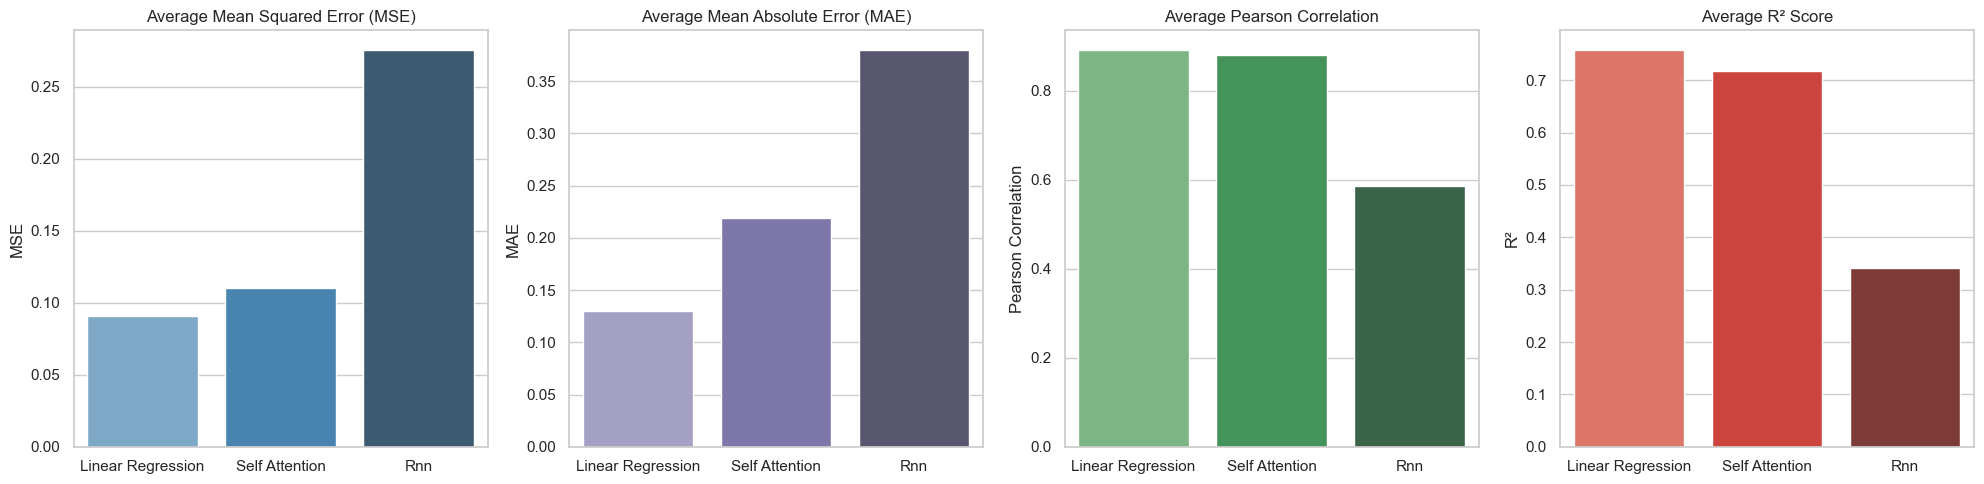

In [7]:
# Calculate and print average results across folds
# models = [m for m in model_config.keys()]
models = [m for m in model_config.keys() if m != 'cross_attention']
avg_results = {}
for model in models:
    mse_avg = np.mean([r['mse'] for r in fold_results[model]])
    mae_avg = np.mean([r['mae'] for r in fold_results[model]])
    pearson_avg = np.mean([r['pearson'] for r in fold_results[model]])
    r2_avg = np.mean([r['r2'] for r in fold_results[model]])
    display_name = model.replace('_', ' ').title()
    print(f"\nAverage {display_name} - MSE: {mse_avg:.4f}, MAE: {mae_avg:.4f}, Avg Pearson Correlation: {pearson_avg:.4f}, R² Score: {r2_avg:.4f}")
    avg_results[model] = {'mse': mse_avg, 'mae': mae_avg, 'pearson': pearson_avg, 'r2': r2_avg}

# Plot results
plot_results(avg_results, models)

## [6] Calculate R² scores for each feature and output a list of top-performing features

In [8]:
# Example usage after model training and prediction
# Assumes model has been trained and predictions are made
self_pred = self_attention_model.predict(test_data_self)

# Load feature names from outcome_data (assuming it's a DataFrame)
import pandas as pd
outcome_df = pd.read_csv(data_files[config['outcome_name']], index_col=0)
feature_names = list(outcome_df.columns)

# Run feature performance analysis
top_features = analyze_feature_performance(test_outcome, self_pred, feature_names=feature_names, top_n=10)

Top 10 Best Predicted Features:
1)  PLEC: R² = 0.9673
2)  LMNA: R² = 0.9615
3)  STXBP1: R² = 0.9596
4)  ANXA2: R² = 0.9582
5)  ITGB1: R² = 0.9565
6)  VIM: R² = 0.9560
7)  KRT19: R² = 0.9534
8)  KRT18: R² = 0.9534
9)  ASPH: R² = 0.9532
10)  KRT7: R² = 0.9498